In [6]:
#pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [46]:
from preprocessing_utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from tqdm import tqdm
from time import sleep
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


survey_data_path = "/Volumes/DeepLearner/MADS/Milestone_data/survey_cleaned.csv"
data_5k_path = "/Volumes/DeepLearner/MADS/Milestone_data/data_5k_cleaned.csv"

In [32]:
df_survey = pd.read_csv(survey_data_path, low_memory=False)
df_survey = df_survey.drop(columns=['Unnamed: 0', 'RECORD_ID'])
df_survey.head(), df_survey.shape

(  ADD_TYPE   AGE AI_COUNTY_NAME  CENSUS_ST  CENSUS_TRK  CNS_MEDINC  \
 0        S  63.0         MARION         18    390602.0       728.0   
 1        S  73.0           POLK         12     14123.0       511.0   
 2        S  86.0    LOS ANGELES          6    403703.0       728.0   
 3        S  55.0          OCEAN         34    714200.0       868.0   
 4        S  73.0      JEFFERSON          8      9832.0       793.0   
 
    CNSUS_PCTA  CNSUS_PCTB  CNSUS_PCTH  CNSUS_PCTI  ...  VTR_PRI20  VTR_PRI21  \
 0    0.000000   30.357143    7.142857         0.0  ...          N          N   
 1    0.000000   28.571429   14.285714         0.0  ...          N          N   
 2   24.324324    0.000000   43.243243         0.0  ...          N          N   
 3    0.000000    0.000000   13.636364         0.0  ...          N          N   
 4    0.000000    8.450704   14.788732         0.0  ...          Y          N   
 
    VTR_PRI22    ZIP           Q1_Candidate                  Q2_Support  \
 0       

In [33]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def preprocess_dataframe(df, use_frequency_encoding=False, drop_converted_cols=True):
    """
    Preprocesses the dataframe based on the specified steps.
    
    Parameters:
        df (DataFrame): Input dataframe.
        use_frequency_encoding (bool): Whether to use frequency encoding for ZIP, State, and County.
        drop_converted_cols (bool): Whether to drop the original columns after encoding.
        
    Returns:
        DataFrame: Preprocessed dataframe.
    """
    print("Starting data preparation...")
    sleep(1)

    df = df.applymap(lambda x: x.upper() if type(x) == str else x)

    df['PRFL_MINWAGE'] = df['PRFL_MINWAGE'].replace('N', 'UNKNOWN')

    # one-Hot Encoding
    one_hot_cols = [
        'CENSUS_ST', 'AI_COUNTY_NAME', 'ADD_TYPE', 'CENSUS_TRK', 'CONG_DIST',
        'COUNTY_TYPE', 'DON_CHARIT', 'DON_POLIT', 'ETHNIC_INFER',
        'GENDER_MIX', 'GENERATION', 'HOMEOWNER', 'HOMEOWNRNT', 'LANGUAGE',
        'LIFESTAGE_CLUSTER', 'PARTY_CODE', 'PARTY_MIX', 'PRESENCHLD', 'RELIGION',
        'SEX', 'ST_LO_HOUS', 'ST_UP_HOUS', 'STATUS'
    ]
    
    #df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

    # Handle PRFL_ columns
    prfl_cols = [col for col in df.columns if col.startswith('PRFL_')]
    df = pd.get_dummies(df, columns=prfl_cols, drop_first=True)

    vtr_cols = [col for col in df.columns if col.startswith('VTR_')]
    df = pd.get_dummies(df, columns=vtr_cols, drop_first=True)

    # splitting Columns
    split_cols = ['TOD_PRES_DIFF_2016', 'TOD_PRES_DIFF_2016_PREC', 'TOD_PRES_DIFF_2020_PREC']
    for col in split_cols:
        df[col + '_num'] = df[col].str.extract('(\d+)').astype('float')
        df[col + '_party'] = df[col].str.extract('([RD])')

    new_one_hot_cols = [col + '_party' for col in split_cols]
    one_hot_cols.extend(new_one_hot_cols)

    df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

    #convert to Int
    int_cols = ['VOTER_CNT', 'TRAIL_CNT', 'CNS_MEDINC', 'HH_SIZE', 'LENGTH_RES', 'PERSONS_HH']
    df[int_cols] = df[int_cols].astype(int)

    # label Encoding
    label_cols = ['CREDRATE', 'EDUCATION', 'HH_SIZE', 'HOMEMKTVAL', 'INCOMESTHH', 'NETWORTH']
    for col in label_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    # drop Columns
    drop_cols = ['ETHNICCODE']
    df.drop(columns=drop_cols, inplace=True)
    
    # frequency Encoding for ZIP, State, and County
    if use_frequency_encoding:
        freq_cols = ['ZIP', 'STATE', 'COUNTY_ST']
        for col in freq_cols:
            freq_map = df[col].value_counts(normalize=True)
            df[col + '_freq'] = df[col].map(freq_map)

    # Drop the original columns if specified
    if drop_converted_cols:
        all_converted_cols = one_hot_cols + int_cols + label_cols + freq_cols + prfl_cols + vtr_cols + split_cols
        all_converted_cols = [col for col in all_converted_cols if col in df.columns]
        df.drop(columns=all_converted_cols, inplace=True)
            
    return df



In [34]:
df_survey = preprocess_dataframe(df_survey, use_frequency_encoding=True, drop_converted_cols=True)
#df_survey.head(), df_survey.shape

Starting data preparation...


/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_20463/801468808.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_num'] = df[col].str.extract('(\d+)').astype('float')
/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_20463/801468808.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_party'] = df[col].str.extract('([RD])')
/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_20463/801468808.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

In [47]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on various metrics and return a dictionary of results.
    """
    y_pred = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted')
    }


def plot_feature_importance(model, feature_names, title=''):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.show()

def prepare_and_fit_model(df, target_col, model_type='All', feature_importance=False, scale_data=False, evaluate_models=False):
    print("Starting data preparation...")
    
    if not np.issubdtype(df[target_col].dtype, np.number):
        le = LabelEncoder()
        df[target_col] = le.fit_transform(df[target_col])

    num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = df.select_dtypes(include=['object']).columns.tolist()

    if target_col in num_features: num_features.remove(target_col)
    if target_col in cat_features: cat_features.remove(target_col)

    num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])
    cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent'))])

    preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

    models = {}
    model_types_to_fit = []

    if model_type in ['RF', 'All']: model_types_to_fit.append('RF')
    if model_type in ['XGBoost', 'All']: model_types_to_fit.append('XGBoost')

    print("Starting model training...")
    evaluation_results = {}

    for model_type in tqdm(model_types_to_fit):
        clf = None

        if model_type == 'RF':
            clf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', RandomForestClassifier(random_state=42))])
        elif model_type == 'XGBoost':
            clf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', XGBClassifier(random_state=42))])

        if clf:
            X = df.drop(columns=[target_col])
            y = df[target_col]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            clf.fit(X_train, y_train)
            models[model_type] = clf
            print(f"{model_type} model trained.")

            if evaluate_models:
                eval_metrics = evaluate_model(clf, X_test, y_test)
                evaluation_results[model_type] = eval_metrics
                print(f"Evaluation metrics for {model_type}: {eval_metrics}")

            if feature_importance:
                feature_names = num_features + cat_features
                plot_feature_importance(clf.named_steps['classifier'], feature_names, title=f'{model_type} - Feature Importance')

    print("Model training complete.")
    if evaluate_models:
        return models, evaluation_results
    else:
        return models

Starting data preparation...
Starting model training...


  0%|          | 0/2 [00:00<?, ?it/s]

RF model trained.
Evaluation metrics for RF: {'Accuracy': 0.391025641025641, 'Precision': 0.28076446628033924, 'Recall': 0.391025641025641, 'F1 Score': 0.31234465946868845}


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


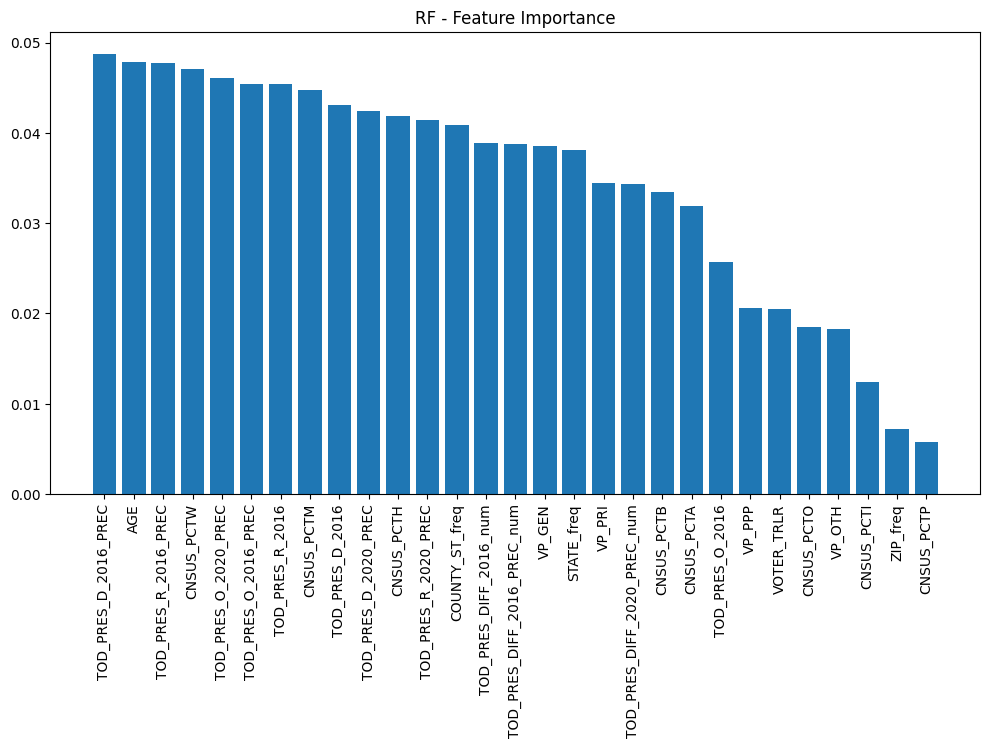

 50%|█████     | 1/2 [00:00<00:00,  2.07it/s]

XGBoost model trained.
Evaluation metrics for XGBoost: {'Accuracy': 0.3525641025641026, 'Precision': 0.2564041884694059, 'Recall': 0.3525641025641026, 'F1 Score': 0.29480708402573935}


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


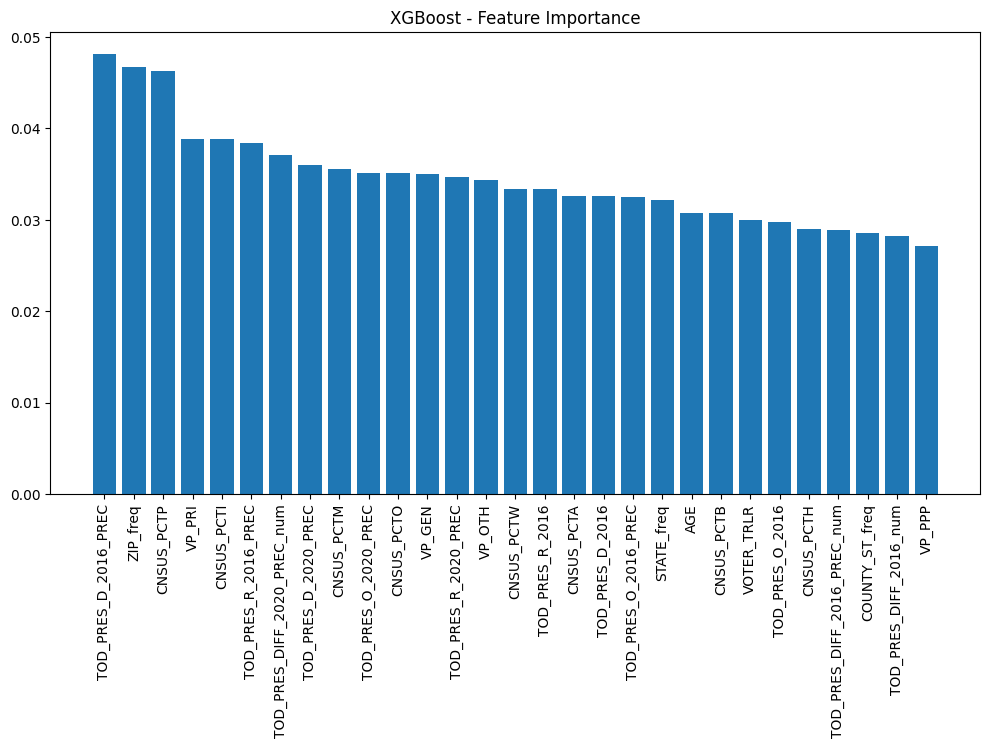

100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

Model training complete.


In [49]:
models = prepare_and_fit_model(df_survey, 'Q1_Candidate', model_type='All', feature_importance=True, scale_data=False, evaluate_models=True)